In [1]:
from catboost import CatBoostClassifier, Pool, metrics
import numpy as np
import pandas as pd
from pandas.api.indexers import FixedForwardWindowIndexer
import shap
from sklearn.base import BaseEstimator, TransformerMixin
import ta
import plotly.express as px
import plotly.graph_objects as go

import os

In [32]:
DATA_DIR = "data"

In [77]:
df = pd.read_csv(os.path.join(DATA_DIR, "btcusd.csv"))

In [78]:
df.time = pd.to_datetime(df.time, unit="ms")

In [88]:
df = df[df.time.dt.year > 2016]

In [45]:
class SmoothingWindowLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, *, window_size=100, alpha=0.004):
        self.window_size = window_size
        self.alpha = alpha
        self.indexer = FixedForwardWindowIndexer(window_size=self.window_size)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        forward_mean = X.close.rolling(self.indexer, min_periods=1).mean()
        backward_mean = X.close.rolling(window=self.window_size).mean()
        X["label"] = (forward_mean - backward_mean) / backward_mean
        less = np.where(X.label < -self.alpha)[0]
        greater = np.where(X.label > self.alpha)[0]
        between = np.setdiff1d(np.arange(X.label.size), np.concatenate((less, greater)))
        mapped_label = X.label.copy()
        mapped_label.iloc[less] = -1
        mapped_label.iloc[greater] = 1
        mapped_label.iloc[between] = 0
        X.label = mapped_label
        return X
    
    def fit_transform(self, X, y=None):
        X = self.transform(X)
        return X

In [89]:
labeler = SmoothingWindowLabeler()

In [90]:
df = labeler.fit_transform(df)

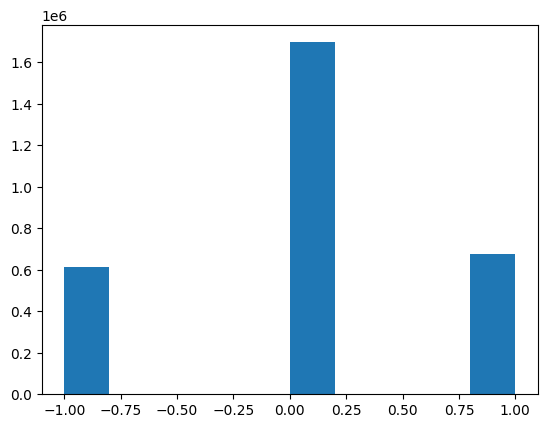

In [91]:
plt.hist(df.label)
plt.show()

In [92]:
df_small = df[-10_000:]
labels = df_small.label.to_numpy()

buy_indices = np.where(labels == 1)[0]
sell_indices = np.where(labels == -1)[0]

fig = px.line(x=range(len(df_small)), y=df_small.close)

fig.add_trace(
    go.Scatter(
        x=buy_indices,
        y=df_small.iloc[buy_indices].close,
        mode="markers",
        line=go.scatter.Line(color="green"),
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        x=sell_indices,
        y=df_small.iloc[sell_indices].close,
        mode="markers",
        line=go.scatter.Line(color="red"),
        showlegend=False
    )
)

fig.show()

In [ ]:
df_all = ta.add_all_ta_features(df[-1_000_000:].copy(), open="open", high="high", low="low", close="close", volume="volume")

In [93]:
df["rsi"] = ta.momentum.rsi(df.close)

In [94]:
df.dropna()

,time,open,close,high,low,volume,rsi,label
1091795,2017-01-01 00:16:00,965.010000,965.360000,965.360000,965.000000,11.260128,32.176934,0.0
1091796,2017-01-01 00:17:00,965.300000,965.050000,965.300000,965.050000,1.291216,28.802487,0.0
1091797,2017-01-01 00:18:00,965.050000,965.830000,965.830000,965.050000,10.510669,44.557487,0.0
1091798,2017-01-01 00:19:00,965.110000,965.110000,965.110000,965.110000,0.400000,36.523236,0.0
1091799,2017-01-01 00:23:00,965.110000,965.110000,965.110000,965.110000,0.242604,36.523236,0.0
...,...,...,...,...,...,...,...,...
4076641,2022-10-11 09:21:00,19095.000000,19093.000000,19095.271568,19093.000000,11.888831,39.269777,0.0
4076642,2022-10-11 09:22:00,19092.000000,19084.000000,19094.000000,19084.000000,3.190573,32.310892,0.0
4076643,2022-10-11 09:23:00,19084.000000,19092.679941,19094.000000,19083.094873,0.972817,42.832648,0.0
4076644,2022-10-11 09:24:00,19093.000000,19094.623019,19098.000000,19093.000000,5.427767,44.897545,0.0


In [96]:
train_df = df[(df.time.dt.year > 2019) & (df.time.dt.year < 2021)]
val_df = df[(df.time.dt.year > 2020) & (df.time.dt.year < 2022)]
test_df = df[df.time.dt.year > 2021]

,time,open,close,high,low,volume,rsi,label
3669799,2022-01-01 00:00:00,46209.000000,46244.000000,46244.000000,46203.000000,0.927772,35.849995,1.0
3669800,2022-01-01 00:01:00,46244.000000,46308.000000,46309.000000,46228.000000,9.384730,46.395333,1.0
3669801,2022-01-01 00:02:00,46309.000000,46363.000000,46363.000000,46301.000000,0.736552,53.473652,1.0
3669802,2022-01-01 00:03:00,46358.000000,46334.127440,46386.000000,46321.000000,2.381914,49.759093,1.0
3669803,2022-01-01 00:04:00,46330.000000,46311.000000,46332.787579,46311.000000,1.608887,46.945946,1.0
...,...,...,...,...,...,...,...,...
4076641,2022-10-11 09:21:00,19095.000000,19093.000000,19095.271568,19093.000000,11.888831,39.269777,0.0
4076642,2022-10-11 09:22:00,19092.000000,19084.000000,19094.000000,19084.000000,3.190573,32.310892,0.0
4076643,2022-10-11 09:23:00,19084.000000,19092.679941,19094.000000,19083.094873,0.972817,42.832648,0.0
4076644,2022-10-11 09:24:00,19093.000000,19094.623019,19098.000000,19093.000000,5.427767,44.897545,0.0


In [102]:
X_train, y_train = train_df[train_df.columns[train_df.columns.isin(["rsi"])]], train_df.label
X_val, y_val = val_df[val_df.columns[val_df.columns.isin(["rsi"])]], val_df.label
X_test, y_test = test_df[test_df.columns[test_df.columns.isin(["rsi"])]], test_df.label

In [106]:
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
test_pool = Pool(X_test, y_test)

In [107]:
classifier = CatBoostClassifier()
classifier.fit(
    train_pool,
    eval_set=[val_pool, test_pool],
    use_best_model=True,
    verbose=200,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.122346
0:	learn: 1.0377462	test: 1.0682222	test1: 1.0472300	best: 1.0472300 (0)	total: 850ms	remaining: 14m 9s
200:	learn: 0.8130726	test: 1.0383924	test1: 0.8809982	best: 0.8808112 (28)	total: 33.3s	remaining: 2m 12s
400:	learn: 0.8129071	test: 1.0385134	test1: 0.8810770	best: 0.8808112 (28)	total: 1m 3s	remaining: 1m 35s
600:	learn: 0.8128406	test: 1.0385971	test1: 0.8811351	best: 0.8808112 (28)	total: 1m 31s	remaining: 1m
800:	learn: 0.8127992	test: 1.0386571	test1: 0.8811747	best: 0.8808112 (28)	total: 2m	remaining: 29.8s
999:	learn: 0.8127743	test: 1.0387070	test1: 0.8812108	best: 0.8808112 (28)	total: 2m 28s	remaining: 0us

bestTest = 0.8808112034
bestIteration = 28

Shrink model to first 29 iterations.
